In [112]:
import warnings
warnings.filterwarnings("ignore")

import os 
from pathlib import Path 
from langchain_ollama import OllamaEmbeddings
import pandas as pd
import matplotlib.pyplot as plt 

import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.documents import Document
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
import torch
import re

In [5]:
data_dir = Path.cwd().parent / 'data'
file_name = 'prelim_data_extracted.csv'

In [6]:
data = pd.read_csv(data_dir / file_name)
data.head()

,Question,Answer
0,What is radiation therapy?,Radiation therapy (also called radiotherapy) i...
1,How is radiation therapy given?,Radiation therapy can be external beam or inte...
2,Who gets radiation therapy?,Many people with cancer need treatment with ra...
3,What does radiation therapy do to cancer cells?,"Given in high doses, radiation kills or slows ..."
4,How long does radiation therapy take to work?,Radiation therapy does not kill cancer cells r...


## Some Text Analysis

In [7]:
# Check if all the Questions are Unique 
print("Total Questions in DataFrame:", data.shape[0])
print("Unique Questions in DataFrame:", data.Question.unique().shape[0])

Total Questions in DataFrame: 115
Unique Questions in DataFrame: 105


In [8]:
# Filter Question with count > 1
# Need to fix these later with Question generation with an LLM
question_counts = data.Question.value_counts()
duplicate_questions = data[data.Question.isin(question_counts[question_counts > 1].index)]
duplicate_questions

,Question,Answer
54,Who will be involved in this procedure?,Most facilities rely on a specially trained te...
55,What equipment is used?,A medical linear accelerator (LINAC) generates...
56,Who operates the equipment?,The radiation therapist operates the equipment...
57,Is there any special preparation needed for th...,"Before planning treatment, a physical examinat..."
58,How is the procedure performed?,IMRT often requires multiple (fractionated) tr...
59,What will I feel during and after the procedure?,As with other external beam radiation therapy ...
61,Who will be involved in this procedure?,"As with other forms of external beam therapy, ..."
62,What equipment is used?,"Proton beam therapy uses special machines, a c..."
63,Who operates the equipment?,"With backgrounds in mechanical, electrical, so..."
64,Is there any special preparation needed for th...,Several preparation steps are needed before a ...


In [9]:
#Drop the duplicate questions 
data = data[~data.Question.isin(question_counts[question_counts > 1].index)]
print("Filtered DataFrame Size:", data.shape[0])

Filtered DataFrame Size: 99


In [ ]:
data.to_csv(data_dir / 'prelim_data_cleaned.csv', index=False)

In [10]:
# Find Sequence Length Distribution for Questions and Answers
def find_sequence_len(x):
    return len(x.split(' '))

data['question_len'] = data['Question'].apply(lambda x : find_sequence_len(x))
data['answer_len'] = data['Answer'].apply(lambda x : find_sequence_len(x))
data.head()

,Question,Answer,question_len,answer_len
0,What is radiation therapy?,Radiation therapy (also called radiotherapy) i...,4,48
1,How is radiation therapy given?,Radiation therapy can be external beam or inte...,5,65
2,Who gets radiation therapy?,Many people with cancer need treatment with ra...,4,34
3,What does radiation therapy do to cancer cells?,"Given in high doses, radiation kills or slows ...",8,87
4,How long does radiation therapy take to work?,Radiation therapy does not kill cancer cells r...,8,35


<Axes: >

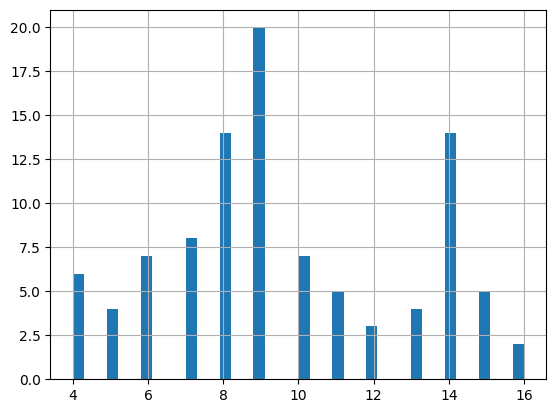

In [11]:
# Plot Question Sequence Len Histogram Distribution
data.question_len.hist(bins=40)

<Axes: >

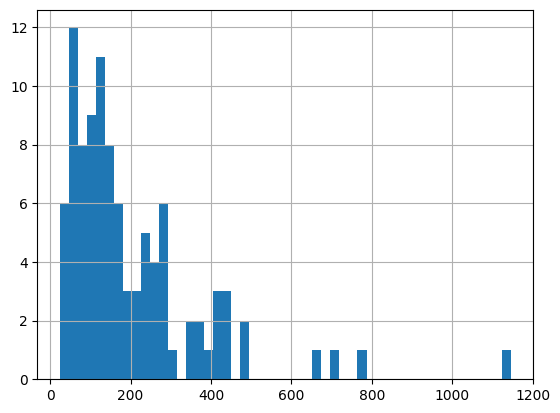

In [12]:
# Plot Answer Sequence Len Histogram Distribution
data.answer_len.hist(bins=50)

- There is no need for chunking to store Questions as they have pretty small sequence length
- For Answers, need to figure out how we should embed them. Options can be : Create separate embeddings of the answer or treat all the answers as documents and embed them

## Approach 1

**Steps**
- Create Vector Database on the Questions
- Given a user query, fetch the topk relevant questions. 
- If highly similar questions are found, then return or re-generate their answers
- else search in the document database ==> Need to implement later

**TODO LATER** : Enhance RAG Architecture with reliable RAG kind of architecture


In [148]:
class Retriever():
    def __init__(self, embedder_config, sim_threshold=0.7, topk=5):
        """
        Initializes the retriever with embedder configuration and vector store.
        :param embedder_config: dict containing embedder backend, model, and params
        :param sim_threshold: minimum similarity threshold for acceptable results
        :param topk: number of top-k similar documents to retrieve
        """
        super().__init__()
        # Initialize the device directly here to avoid issues
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.sim_threshold = sim_threshold
        self.topk = topk
        self.db = pd.DataFrame(columns=["Question", "Answer"])
        
        self.init_embedder(embedder_config)
        self.init_vector_store()
        print("Vector Store Initialized")
    
    def init_vector_store(self):
        # Create the FAISS index for storing embeddings
        embedding_size = len(self.embedder.embed_query("hello world"))  # Example to get embedding size
        index = faiss.IndexFlatL2(embedding_size)
        
        self.vector_store = FAISS(
            embedding_function=self.embedder,
            index=index,
            docstore=InMemoryDocstore(),
            index_to_docstore_id={}
        )

    def init_embedder(self, embedder_config):
        """
        Initializes the embedder based on the provided configuration.
        :param embedder_config: dict with backend, model_name, and encode_kwargs
        """
        embedder_params = embedder_config['params']
        if embedder_config['backend'] == "HF":
            self.embedder = HuggingFaceEmbeddings(
                model_name=embedder_params['model_name'],
                model_kwargs={'device': self.device},
                encode_kwargs=embedder_params.get('encode_kwargs', {})
            )
            print(f"Embedder Initialized with {embedder_params['model_name']}")
        elif embedder_config['backend'] == "OLLAMA":
            self.embedder = OllamaEmbeddings(model=embedder_params['model_name'])
            print(f"Embedder Initialized with {embedder_params['model_name']}")
        else:
            raise NotImplementedError("Embedder backend not supported")

    @staticmethod
    def preprocess_text(text):
        """
        Preprocess the input text for embedding by normalizing and cleaning.
        :param text: input string to preprocess
        :return: cleaned and preprocessed string
        """
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
        return text

    def add_documents_from_df(self, df, key):
        """
        Adds documents to the vector store from a DataFrame.
        :param df: pandas DataFrame containing Q/A pairs
        :param key: column name for the question to embed
        """
        assert key in df.columns, f"Invalid key. {key} not found in DataFrame."
        self.db = pd.concat([self.db, df])
        self.search_key = key

        # Preprocess the text before adding
        self.db[self.search_key] = self.db[self.search_key].apply(lambda x: self.preprocess_text(x))

        text_list = self.db[self.search_key].tolist()
        document_ids = self.db.index.tolist()

        documents = []
        for text, doc_id in zip(text_list, document_ids):
            _ = Document(
                page_content=text,
                metadata={"id" : doc_id}
            )
            documents.append(_)        
        
        self.vector_store.add_documents(documents=documents, ids=document_ids)
        print(f"Added {len(documents)} documents to the vector store")

    def _retrieve_topk(self, query, topk=None):
        """
        Retrieve the top-k most similar documents for the given query.
        :param query: input query string
        :param topk: number of documents to retrieve
        :return: list of tuples with document and similarity score
        """
        topk = topk or self.topk  # Use default topk if not provided
        query = self.preprocess_text(query)
        results = self.vector_store.similarity_search_with_relevance_scores(query, k=topk)
        return results

    def retrieve(self, query, topk=5, sim_threshold=0.4):
        """
        Retrieve the most relevant documents based on similarity threshold.
        :param query: input query string
        :param topk: number of top-k similar documents to retrieve
        :param sim_threshold: similarity threshold for filtering results
        :return: list of relevant documents
        """
        sim_threshold = sim_threshold or self.sim_threshold
        result = self._retrieve_topk(query, topk)

        # Filter results by similarity threshold
        response_list = []
        for doc, score in result:
            if score >= sim_threshold:
                try:
                    ques = doc.page_content
                    answer = self.db.iloc[doc.metadata['id']]['Answer']
                    response_list.append((ques, answer, score))
                except:
                    continue
            else:
                break  # Stop as scores are sorted by similarity
        
        if len(response_list) == 0:
            print("No result meets the similarity threshold.")
            return []
        return response_list

In [149]:
embedder_config = {
    "backend" : "HF", 
    "params" : {
        "model_name" : "sentence-transformers/all-mpnet-base-v2",
        "encode_kwargs" : {'normalize_embeddings': False}
    }
}

retriever = Retriever(embedder_config=embedder_config)
retriever.add_documents_from_df(df=data, key="Question")

Embedder Initialized with sentence-transformers/all-mpnet-base-v2
Vector Store Initialized
Added 99 documents to the vector store


In [111]:
retriever.retrieve(query="Can you please explain what does radiation therapy do to cancer cells?")

[('what does radiation therapy do to cancer cells',
  'Given in high doses, radiation kills or slows the growth of cancer cells. Radiation therapy is used to: \n1. Treat cancer. Radiation can be used to cure cancer, to prevent it from returning, or to stop or slow its growth. \n\n2. Reduce symptoms. When a cure is not possible, radiation may be used to treat pain and other problems caused by the cancer tumor. Or, it can prevent problems that may be caused by a growing tumor, such as blindness or loss of bowel and bladder control.',
  0.8568510317981743),
 ('what does radiation therapy do to healthy cells',
  'Radiation not only kills or slows the growth of cancer cells, it can also affect nearby healthy cells. The healthy cells almost always recover after treatment is over. But sometimes people may have side effects that are severe or do not get better. Other side effects may show up months or years after radiation therapy is over. These are called late side effects. \n\nDoctors try to

In [88]:
retriever.retrieve(query="How external beam therapy is useful for treating cancer?")

[(Document(metadata={}, page_content='what is external beam radiation therapy'),
  0.7004721678487792)]

In [89]:
retriever.retrieve(query="What kind of treatments are suggested for lymphoma cancer?")

No result meets the similarity threshold.


[]

In [90]:
retriever.retrieve(query="What kind of treatments do you prescribe for prostrate cancer?")

No result meets the similarity threshold.


[]

In [91]:
retriever.retrieve(query="Is radiation treatment good for head and neck cancer?")

[(Document(metadata={}, page_content='what are possible risks and complications of radiation therapy in head and neck cancer'),
  0.7818365113850902),
 (Document(metadata={}, page_content='what are possible side effects of radiation therapy for head and neck cancer'),
  0.7247160466366096),
 (Document(metadata={}, page_content='what happens during radiation therapy for head and neck cancer'),
  0.7147979448779048)]

In [92]:
retriever.retrieve(query="what will happen to me during anal cancer radiation therapy?")

[(Document(metadata={}, page_content='what happens during radiation therapy for anal cancer'),
  0.8671408476873211),
 (Document(metadata={}, page_content='what are possible side effects risks and complications of radiation therapy in anal cancer'),
  0.819258276709428),
 (Document(metadata={}, page_content='what kind of treatment followup should i expect for radiation therapy of anal cancer'),
  0.7396518360776578)]

In [93]:
retriever.retrieve(query="What are the side effects for radiation treatment for anal cancer?")

[(Document(metadata={}, page_content='what are possible side effects risks and complications of radiation therapy in anal cancer'),
  0.9392778657753088),
 (Document(metadata={}, page_content='what happens during radiation therapy for anal cancer'),
  0.8680842943545253),
 (Document(metadata={}, page_content='how effective is modern radiation treatment of anal cancer'),
  0.7501327247045286),
 (Document(metadata={}, page_content='what kind of treatment followup should i expect for radiation therapy of anal cancer'),
  0.7461160668211676)]

In [188]:
class Answer(BaseModel):
    """Generated response to a user's query based on retrieved context."""
    answer: str = Field(description="The generated answer based on the retrieved context and user query.")


# The generator class using the above Langchain structure
class OllamaGenerator:
    def __init__(self, model_name='llama3.1:8b'):
        """
        Initializes the OllamaGenerator with a specified model and fallback message.
        :param model_name: name of the Ollama model to use for generation.
        :param fallback_message: default message if no confident answer can be generated.
        """
        self.model_name = model_name
        llm = ChatOllama(model=self.model_name, temperature=0.4)
        structured_llm = llm.with_structured_output(Answer)
        prompt = self.init_prompt()
        self.generation_chain = prompt | structured_llm 

    
    def init_prompt(self):
        system_message = (
            "system",
            """
            You are a highly accurate medical assistant. Based on the provided CONTEXT, generate a concise and accurate answer to the USER_QUERY.
            Ensure the answer is precise, relevant, and does not hallucinate. If the CONTEXT does not provide sufficient information, return 'No answer available.'
            """
        )


        prompt = ChatPromptTemplate.from_messages(
            [   
                system_message,
                (
                    "human", 
                    """
                    CONTEXT: {context}
                    USER_QUERY: {user_query}
                    """
                ),
            ]
        )
        return prompt
    
    def generate(self, retrieved_context, user_query):
        """
        Generate a response using Ollama ChatLLM based on retrieved context and user query.
        :param retrieved_context: The context (retrieved answers) provided from the retriever.
        :param user_query: The original user query for which an answer is being generated.
        :return: Generated response or fallback message.
        """
        if not retrieved_context or all(ctx[1].strip() == '' for ctx in retrieved_context):
            # If no context is provided or all retrieved answers are empty
            return "No answer available."

        # Combine all the retrieved answers into a single string for the model prompt
        context_text = "\n".join([f"Q: {ctx[0]}\nA: {ctx[1]}" for ctx in retrieved_context])
        
        # Prepare input for the prompt template
        inputs = {
            "context": context_text,
            "user_query": user_query
        }

        # Execute the generation chain
        response = self.generation_chain.invoke(inputs)

        # Return the generated answer, or fallback if no response
        return response.answer if response else "No answer available."


In [189]:
embedder_config = {
    "backend" : "HF", 
    "params" : {
        "model_name" : "sentence-transformers/all-mpnet-base-v2",
        "encode_kwargs" : {'normalize_embeddings': False}
    }
}

retriever = Retriever(embedder_config=embedder_config)
retriever.add_documents_from_df(df=data, key="Question")
generator = OllamaGenerator(model_name='llama3.1:70b')

Embedder Initialized with sentence-transformers/all-mpnet-base-v2
Vector Store Initialized
Added 99 documents to the vector store


In [190]:
user_query = "What are the post radiation therapy symptoms?"

retrieved_context = retriever.retrieve(query=user_query)
for result in retrieved_context:
    print(result[0], result[2])

print("Generating Answer...")

response = generator.generate(retrieved_context, user_query)
print(response)

after i have finished radiation therapy what symptoms should i look for 0.7747781786649709
what happens when radiation therapy is over 0.587280357704951
what happens during radiation therapy for breast cancer 0.5634948258946766
does radiation therapy hurt 0.5538839957350403
Generating Answer...
After finishing radiation therapy, look for symptoms such as pain that does not go away, new lumps or swellings, appetite changes, nausea, vomiting, diarrhea, constipation, weight loss, fever, cough, or hoarseness that does not go away. Report any of these symptoms to your doctor or nurse.


In [191]:
user_query = "Treatment sessions can be really tough. What do you suggest what shall I do for pleasure?"

retrieved_context = retriever.retrieve(query=user_query)
for result in retrieved_context:
    print(result[0], result[2])

print("Generating Answer...")

response = generator.generate(retrieved_context, user_query)
print(response)

how can i relax during my treatment sessions 0.5322399031507559
what happens during a treatment session 0.4559210642168051
Generating Answer...
Bring something to keep you busy in the waiting room, such as a book or magazine, crossword puzzles, or knitting. Use headphones to listen to music or recorded books. Meditate, breathe deeply, pray, use imagery, or find other ways to relax.


In [163]:
# while True: 
#     user_query = input()

#     if user_query == "exit":
#         break

#     retrieved_context = retriever.retrieve(query=user_query)
#     for result in retrieved_context:
#         print(result[0], result[2])

#     print("Generating Answer...")

#     response = generator.generate(retrieved_context, user_query)
#     print(response)